# Zinc Corrosion Simulator

## Overview

This is a simulation of zinc corrosion under atmospheric conditions.  The meteorological data is from the NOAA and measured at specific geographic locations. 

Zinc corrosion is a complex process which is highly dependent on the local chemistry.  In this model, several simplifying assumptions are made.  I plan to incorporate the influence of sulphur dioxide at a later date.  It is intended as a hypothesis testing tool.

The model is contained in a corrosion module which is located in this repository.  A virtual zinc plate is imported and subjected to weather conditions which are pulled from an SQL database.  It is a time-marching scheme which stores the history of each instance variable for post processing.

### Assumptions

1. Corrosion is a driven by moisture/precipitation.
2. Corrosion due to exposure to humidity will be first order mass action.  This corrosion will only occur above a critical humidity of 50%. 
3. 80% of corrosion products produced by exposure to humidity are water soluble.
4. Rate of corrosion is independent of corrosion products accumulated on the surface.
5. During a precipitation event, runoff of accumulated corrosion products will be first order mass action and loss of metal due to ionic dissociation will be zeroith order mass action.
6. All weather events maintain a uniform distribution within the sample interval.
7. Both corrosion and runoff events are independent of pH.$^1$  

$^1$This is obviously not correct.  The influence of sulpher dioxide will be added in the future.

### Sample Calculations

#### Corrosion event

The corrosion occurs only on the surface, if the surface area changes slowly compared to the length of the simulation we can write the change in mass due to corrosion as:

$ \frac{dM_P}{dt} = kRH$ <br>

where $M_P$ is the mass of the corrosion products, $RH$ is the relative humidity, and $k_{c}$ is the corrosion rate constant.  Using a basic time-marching numerical integration, this equation discretizes to:

$\Delta M_P = k_{c}RH\Delta t$

However, we are assuming that 80% of the corrosion products are water soluble, leaving 20% insoluble.  We'll calculate each batch of corrosion products as follows.

$\Delta M_{SP} = 0.8 \cdot \Delta M_P$

$\Delta M_{IP} = 0.2 \cdot \Delta M_P$

where $M_{SP}$ is the mass of the soluble corrosion products and $M_{IP}$ is the mass of the insoluble corrosion products.

#### Runoff event

The runoff event occurs uniformly over the surface.  Any measurable precipitation results in a zeroith order loss if soluble corrosion products which is written as:

$\Delta M_{SP} = k_{r}\Delta t$

where $k_{r}$ is the runoff rate constant. 

The volume of effluent during a precipitation event is calculated as:

$ V = P \cdot A $ 

where $V$ is the volume, $P$ is the depth of measured precipitation, and $A$ is the surface area of the zinc plate.  In the corrosion module, it is assumed that $A=1.0 m^2$.

The concentration of the runoff is calculated as:

$c = \frac{\Delta M_{SP}}{V}$

#### Unit conversion

The density of zinc is given as:

$\rho = 7.14 g/cm^3$

The dimensions of the zinc plate are $100cm$ x $100cm$ x $1mm$, so we can calculate the volume as:

$V$ = $100cm$ x $100cm$ x $0.1cm$ = $1000 cm^3$

The thickness loss will be reported in micrometers. The following conversion is used to convert from micrometers of thickness to grams:

$1\mu m$ x $100cm$ x $100cm$ = 1 $cm^3$



#### Package management

In [1]:
import matplotlib.pyplot as plt
import mysql.connector
import datetime
import matplotlib.dates as mdates
from corrosion import zinc_plate, weather

#### Connect to NOAA Hourly database and get timestamped temperature, humidity, and precipitation values.

In [2]:
cnx = mysql.connector.connect(user='python_connection',
                              password='demo_pass',
                              database='NOAA_hourly')

cursor = cnx.cursor()

query = """SELECT DATE, HOURLYDRYBULBTEMPC, HOURLYRelativeHumidity, HOURLYPrecip FROM san_juan_PR
           WHERE year(DATE) = 2012 OR year(DATE) = 2013;"""

cursor.execute(query)

#### Generate weather and zinc_plate instances.    

In [3]:
zp = zinc_plate()

w = weather()

#### Loop through rows in cursor and call methods on zp and w.  

In [4]:
for row in cursor:
    
    # store weather data
    w.get_conditions(row[0],row[1],row[2],row[3])

    # time stamp the zinc plate
    zp.time_domain.append(row[0])

    # zinc plate corrodes from exposure to humidity
    zp.corrode(row[2])

    # zinc plate experiences a runoff event from precipitation
    zp.runoff(row[3])

# set the time stamp for the initial conditions
dt_obj = zp.time_domain[0] - datetime.timedelta(hours=1)
zp.time_domain.insert(0,dt_obj)

#### Report total loss of zinc.




In [5]:
print('\n\nZinc thickness loss: ',zp.thickness[0]-zp.thickness[-1],' micrometers')

print('\nZinc mass loss: ',((zp.thickness[0]-zp.thickness[-1])*7.14),' grams \n\n')

total_runoff = 0

for i in range(len(zp.effluent_volume)):
    total_runoff += (zp.effluent_volume[i] * zp.effluent_concentration[i])
    
print('Total runoff: ', total_runoff, ' grams \n')
print('Corrosion products on plate: ', ((zp.soluble_products[-1] + zp.insoluble_products[-1])*7.14), ' grams\n\n')


print('Mass conservation check:\n\nInitial thickness = ',zp.thickness[0],' micrometers\n')
print('Normalized cumulative thickness at final time step = ',((zp.soluble_products[-1] + zp.insoluble_products[-1]))+(total_runoff/7.14)+zp.thickness[-1],' micrometers')





Zinc thickness loss:  1.952166600123519  micrometers

Zinc mass loss:  13.938469524881924  grams 


Total runoff:  11.001325743497606  grams 

Corrosion products on plate:  2.9371437805024367  grams


Mass conservation check:

Initial thickness =  1000.0  micrometers

Normalized cumulative thickness at final time step =  999.9999999998765  micrometers


## Post processing

#### Plot zinc plate mass over the duration of the simulation.

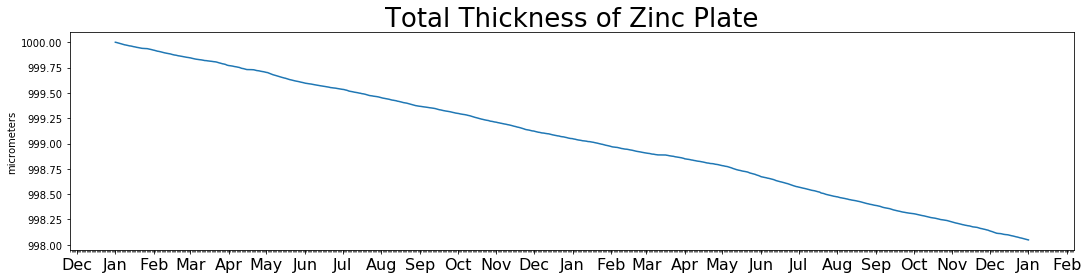

In [6]:
months = mdates.MonthLocator()  
monthsFmt = mdates.DateFormatter('%b') 
days = mdates.DayLocator()

fig, ax = plt.subplots(figsize=(18,4))
ax.plot(zp.time_domain,zp.thickness)
ax.set_title('Total Thickness of Zinc Plate', fontsize=26)
ax.set_ylabel('micrometers')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.show()

#### Plot the soluble corrosion products.

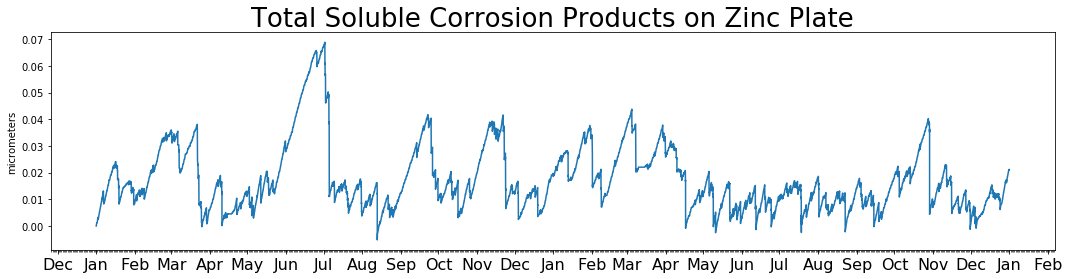

In [7]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(zp.time_domain,zp.soluble_products)
ax.set_title('Total Soluble Corrosion Products on Zinc Plate', fontsize=26)
ax.set_ylabel('micrometers')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.show()

#### Plot the insoluble corrosion products.  

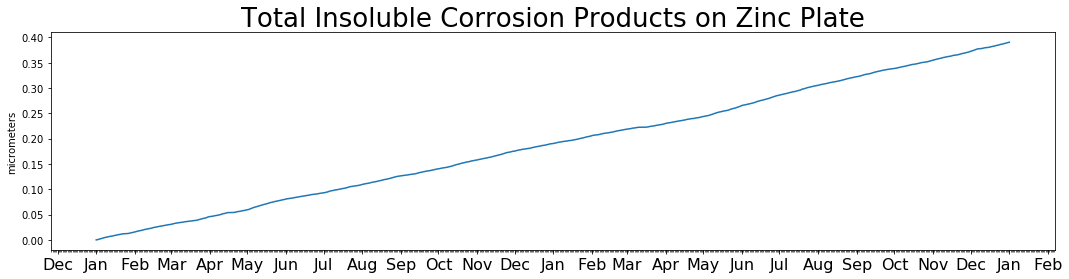

In [8]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(zp.time_domain,zp.insoluble_products)
ax.set_title('Total Insoluble Corrosion Products on Zinc Plate', fontsize=26)
ax.set_ylabel('micrometers')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.show()

#### Plot the measured precipitation, calculated effluent volume, and concentration of soluble corrosion products in the effluent.

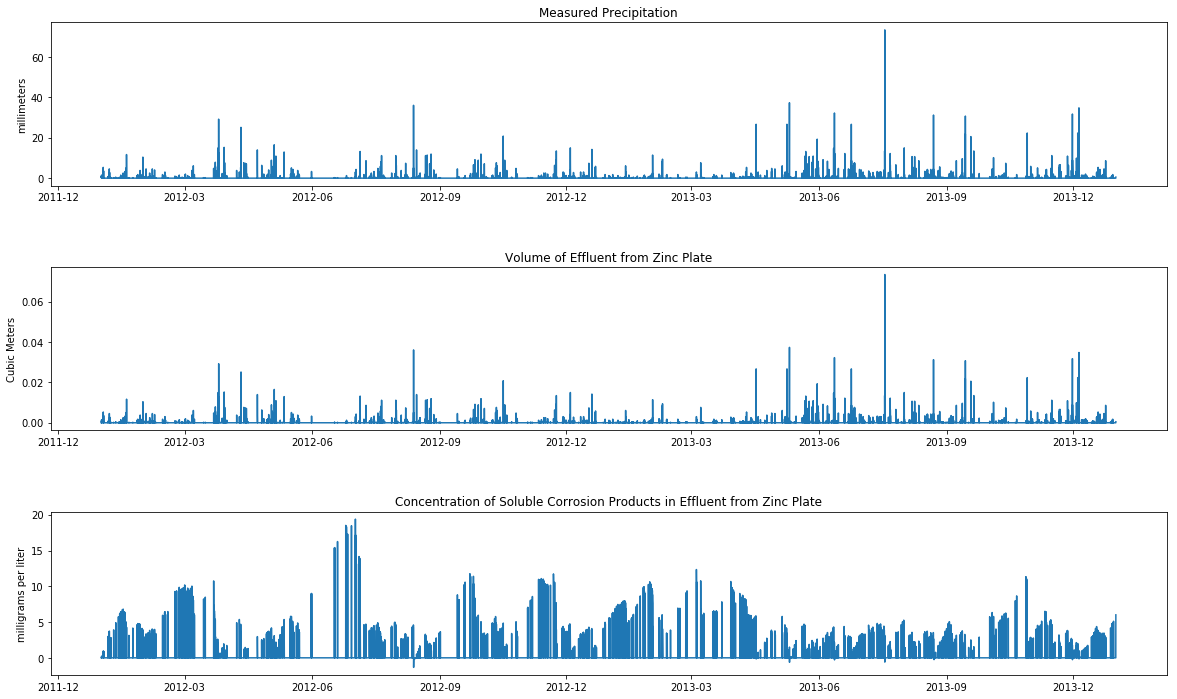

In [9]:
# initialize figure
f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (20,12))
plt.subplots_adjust(hspace=0.5)

ax1.plot(w.time_domain,w.precip)
ax1.set_title('Measured Precipitation')
ax1.set_ylabel('millimeters')

ax2.plot(zp.time_domain,zp.effluent_volume)
ax2.set_title('Volume of Effluent from Zinc Plate')
ax2.set_ylabel('Cubic Meters')

ax3.plot(zp.time_domain,zp.effluent_concentration)
ax3.set_title('Concentration of Soluble Corrosion Products in Effluent from Zinc Plate')
ax3.set_ylabel('milligrams per liter')

plt.show()

#### Meteorological data

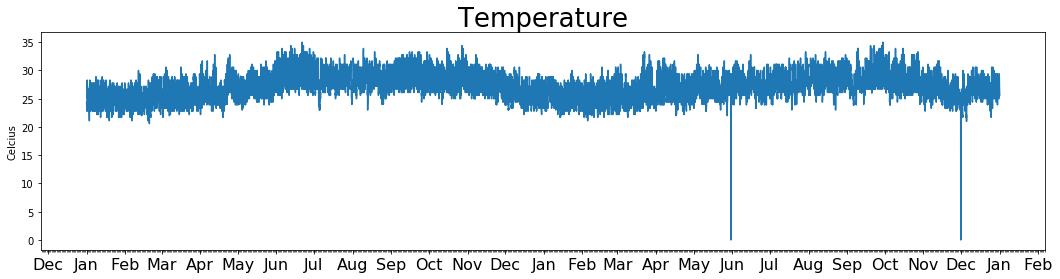

In [10]:

fig, ax = plt.subplots(figsize=(18,4))
ax.plot(w.time_domain,w.temp)
ax.set_title('Temperature', fontsize=26)
ax.set_ylabel('Celcius')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.show()


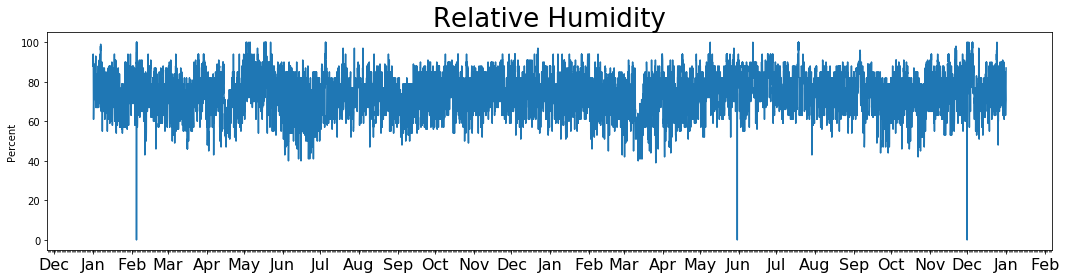

In [11]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(w.time_domain,w.RH)
ax.set_title('Relative Humidity', fontsize=26)
ax.set_ylabel('Percent')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(days)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.show()